In [1]:
#########################################
# 1. IMPORT LIBRARIES & SET GLOBAL VARS #
#########################################

import os
from os.path import exists
import glob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import fcluster

from sklearn.linear_model import RidgeCV  # using RidgeCV with a fixed alpha
from sklearn.metrics import r2_score as r2_score_sklearn

import gdown

# Threshold used for selecting reliable voxels.
NCSNR_THRESHOLD = 0.2

In [2]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import sys
import os

import pickle

In [3]:
#########################################
# 2. HELPER FUNCTIONS                   #
#########################################

def r2_over_nc(y, y_pred, ncsnr):
    """
    Compute the R^2 score normalized by the noise ceiling (NC) as in Finzi et al (2022).
    The noise ceiling is computed as:
         NC = ncsnr^2 / (ncsnr^2 + 1/num_trials)
    If ncsnr is None, return the standard R^2.
    """
    ### TODO: Replace the code below with your implementation.
    # Instructions:
    # 1. If ncsnr is None, compute and return the standard R^2 score using
    #    r2_score_sklearn (with multioutput="raw_values").
    # 2. Otherwise, assume there are 3 target trials (i.e. set num_trials = 3.0).
    # 3. Compute the noise ceiling (NC) using the formula:
    #       NC = (ncsnr ** 2) / ( (ncsnr ** 2) + (1.0 / num_trials) )
    # 4. Compute the standard R^2 score (using r2_score_sklearn) and then
    #    return the normalized R^2 score by dividing the R^2 score by NC.
    pass


def get_metadata_concat_hemi(Y):
    """
    Concatenate left- and right-hemisphere metadata for voxels labeled 'nsdgeneral'
    and return the corresponding ncsnr values and metadata DataFrame.
    """
    ncsnr_full = np.concatenate((
        Y['voxel_metadata']['lh']['lh.ncsnr'],
        Y['voxel_metadata']['rh']['rh.ncsnr']
    ))
    
    nsdgeneral_idx = np.concatenate((
        Y['voxel_metadata']['lh']['lh.nsdgeneral.label'],
        Y['voxel_metadata']['rh']['rh.nsdgeneral.label']
    ))
    nsdgeneral_mask = np.logical_and(nsdgeneral_idx == 'nsdgeneral', ncsnr_full > 0)
    ncsnr_nsdgeneral = ncsnr_full[nsdgeneral_mask]
    
    metadata_lh = pd.DataFrame(Y['voxel_metadata']['lh'])
    metadata_rh = pd.DataFrame(Y['voxel_metadata']['rh'])
    nsdgeneral_metadata_df = pd.concat([metadata_lh, metadata_rh])[nsdgeneral_mask]
    
    return ncsnr_nsdgeneral, nsdgeneral_metadata_df


def get_data_dict(Y, brain_data_rep_averaged, ncsnr_nsdgeneral, nsdgeneral_metadata_df, verbose=True):
    """
    For each brain area (both streams and visual ROIs), select voxels with reliable responses
    (ncsnr above threshold) and return a dictionary with responses and ncsnr values.
    """
    data_dict = {}

    # Process streams-based areas.
    for area in ['ventral', 'parietal', 'lateral']:
        data_dict[area] = {}
        lh_area_mask = nsdgeneral_metadata_df['lh.streams.label'].astype(str).str.contains(area, na=False)
        rh_area_mask = nsdgeneral_metadata_df['rh.streams.label'].astype(str).str.contains(area, na=False)
        area_mask = np.logical_or(lh_area_mask, rh_area_mask)
        area_mask = np.logical_and(area_mask, ncsnr_nsdgeneral > NCSNR_THRESHOLD)
        
        if verbose:
            print(f"Size of area {area}: {np.sum(area_mask)}")
        
        area_data = brain_data_rep_averaged[:, area_mask]
        data_dict[area]["responses"] = area_data.copy()
        data_dict[area]["ncsnr"] = ncsnr_nsdgeneral[area_mask].copy()
        
        if verbose:
            print(f"Shape of area {area} responses: {data_dict[area]['responses'].shape}")

    # Process visual ROIs.
    for area in ['V1', 'V2', 'V3', 'V4']:
        data_dict[area] = {}
        lh_area_mask = nsdgeneral_metadata_df['lh.prf-visualrois.label'].astype(str).str.contains(area, na=False)
        rh_area_mask = nsdgeneral_metadata_df['rh.prf-visualrois.label'].astype(str).str.contains(area, na=False)
        area_mask = np.logical_or(lh_area_mask, rh_area_mask)
        area_mask = np.logical_and(area_mask, ncsnr_nsdgeneral > NCSNR_THRESHOLD)
        
        if verbose:
            print(f"Size of area {area}: {np.sum(area_mask)}")
        
        area_data = brain_data_rep_averaged[:, area_mask]
        data_dict[area]["responses"] = area_data.copy()
        data_dict[area]["ncsnr"] = ncsnr_nsdgeneral[area_mask].copy()
        
        if verbose:
            print(f"Shape of area {area} responses: {data_dict[area]['responses'].shape}")

    return data_dict

In [5]:
#########################################
# 3. DOWNLOAD & LOAD NSD DATA           #
#########################################

# Create a data directory if it does not exist.
datadir = os.path.join(os.getcwd(), 'data')
os.makedirs(datadir, exist_ok=True)

# Define subject and corresponding file_id.
subj = 'subj01'  # choose subject: available subjects are subj01, subj02, subj05, subj07
overwrite = False

if subj == 'subj01':
    file_id = '13cRiwhjurCdr4G2omRZSOMO_tmatjdQr'
elif subj == 'subj02':
    file_id = '1MO9reLoV4fqu6Weh4gmE78KJVtxg72ID'
elif subj == 'subj05':
    file_id = '11dPt3Llj6eAEDJnaRy8Ch5CxfeKijX_t'
elif subj == 'subj07':
    file_id = '1HX-6t4c6js6J_vP4Xo0h1fbK2WINpwem'
    
url = f'https://drive.google.com/uc?id={file_id}&export=download'
output = os.path.join(datadir, f'{subj}_nativesurface_nsdgeneral.pkl')

if not exists(output) or overwrite:
    gdown.download(url, output, quiet=False)

# Load NSD data.
Y = np.load(output, allow_pickle=True)
print("Keys in Y:", Y.keys())

# Print shapes of image bricks for each partition.
for partition in ['train', 'val', 'test']:
    print(f"Shape of image brick ({partition}):", Y['image_data'][partition].shape)


Keys in Y: dict_keys(['image_data', 'brain_data', 'voxel_metadata', 'image_metadata'])
Shape of image brick (train): (1000, 425, 425, 3)
Shape of image brick (val): (1000, 425, 425, 3)
Shape of image brick (test): (1000, 425, 425, 3)


In [38]:
#########################################
# 3. DOWNLOAD & LOAD NSD DATA           #
#########################################

# Create a data directory if it does not exist.
datadir = os.path.join(os.getcwd(), 'data')
os.makedirs(datadir, exist_ok=True)

# Define subject and corresponding file_id.
subj = 'subj07'  # choose subject: available subjects are subj01, subj02, subj05, subj07
overwrite = False

if subj == 'subj01':
    file_id = '13cRiwhjurCdr4G2omRZSOMO_tmatjdQr'
elif subj == 'subj02':
    file_id = '1MO9reLoV4fqu6Weh4gmE78KJVtxg72ID'
elif subj == 'subj05':
    file_id = '11dPt3Llj6eAEDJnaRy8Ch5CxfeKijX_t'
elif subj == 'subj07':
    file_id = '1HX-6t4c6js6J_vP4Xo0h1fbK2WINpwem'
    
url = f'https://drive.google.com/uc?id={file_id}&export=download'
output = os.path.join(datadir, f'{subj}_nativesurface_nsdgeneral.pkl')

if not exists(output) or overwrite:
    gdown.download(url, output, quiet=False)

# Load NSD data.
Y = np.load(output, allow_pickle=True)
print("Keys in Y:", Y.keys())

# Print shapes of image bricks for each partition.
for partition in ['train', 'val', 'test']:
    print(f"Shape of image brick ({partition}):", Y['image_data'][partition].shape)


Downloading...
From (original): https://drive.google.com/uc?id=1HX-6t4c6js6J_vP4Xo0h1fbK2WINpwem&export=download
From (redirected): https://drive.google.com/uc?id=1HX-6t4c6js6J_vP4Xo0h1fbK2WINpwem&export=download&confirm=t&uuid=6dfd146c-778f-4bd1-8db9-21309a8939f9
To: /Users/sharvey/Documents/decoding-similarity/data/subj07_nativesurface_nsdgeneral.pkl
100%|██████████| 6.19G/6.19G [07:51<00:00, 13.1MB/s]


Keys in Y: dict_keys(['image_data', 'brain_data', 'voxel_metadata', 'image_metadata'])
Shape of image brick (train): (1000, 425, 425, 3)
Shape of image brick (val): (1000, 425, 425, 3)
Shape of image brick (test): (1000, 425, 425, 3)


In [6]:

#########################################
# 5. PREPARE FMRI DATA                  #
#########################################

# Concatenate full brain ncsnr and nsdgeneral labels.
ncsnr_full = np.concatenate((
    Y['voxel_metadata']['lh']['lh.ncsnr'].values,
    Y['voxel_metadata']['rh']['rh.ncsnr'].values
))
nsdgeneral_idx = np.concatenate((
    Y['voxel_metadata']['lh']['lh.nsdgeneral.label'].values,
    Y['voxel_metadata']['rh']['rh.nsdgeneral.label'].values
))
print(ncsnr_full.shape, round(np.mean(ncsnr_full), 4), round(np.std(ncsnr_full), 4))
print(np.unique(nsdgeneral_idx))
print(np.count_nonzero(nsdgeneral_idx == 'nsdgeneral'))

# Select only nsdgeneral voxels with positive ncsnr.
nsdgeneral_mask = np.logical_and(nsdgeneral_idx == 'nsdgeneral', ncsnr_full > 0)
ncsnr_nsdgeneral = ncsnr_full[nsdgeneral_mask]
print(ncsnr_nsdgeneral.shape, round(np.mean(ncsnr_nsdgeneral), 4), round(np.std(ncsnr_nsdgeneral), 4))

# Combine metadata for nsdgeneral voxels.
nsdgeneral_metadata = pd.concat((
    Y['voxel_metadata']['lh'],
    Y['voxel_metadata']['rh']
))[nsdgeneral_mask]
ncsnr_nsdgeneral, nsdgeneral_metadata_df = get_metadata_concat_hemi(Y)

# Concatenate train and validation brain data and average over repetitions.
train_brain_data_cat = np.concatenate((
    Y['brain_data']['train']['lh'],
    Y['brain_data']['train']['rh']
), axis=2)
val_brain_data_cat = np.concatenate((
    Y['brain_data']['val']['lh'],
    Y['brain_data']['val']['rh']
), axis=2)
train_brain_data_cat = np.concatenate((train_brain_data_cat, val_brain_data_cat), axis=0)
train_brain_data_cat = np.mean(train_brain_data_cat, axis=1)

# Average test brain data over repetitions.
test_brain_data_cat = np.concatenate((
    Y['brain_data']['test']['lh'],
    Y['brain_data']['test']['rh']
), axis=2)
test_brain_data_cat = np.mean(test_brain_data_cat, axis=1)

# Get fMRI data dictionaries for train and test sets.
train_fmri_data = get_data_dict(Y, train_brain_data_cat, ncsnr_nsdgeneral, nsdgeneral_metadata_df)
test_fmri_data = get_data_dict(Y, test_brain_data_cat, ncsnr_nsdgeneral, nsdgeneral_metadata_df)

# Use both train and validation images for training.
train_image_data = np.concatenate((Y['image_data']['train'], Y['image_data']['val']), axis=0)
test_image_data = Y['image_data']['test']

# Define a torchvision transform: resize, center crop, convert to tensor, and normalize.
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


(453622,) 0.2057 0.1881
['n/a' 'nsdgeneral']
69609
(69556,) 0.5064 0.2213
Size of area ventral: 18378
Shape of area ventral responses: (2000, 18378)
Size of area parietal: 10377
Shape of area parietal responses: (2000, 10377)
Size of area lateral: 13388
Shape of area lateral responses: (2000, 13388)
Size of area V1: 6999
Shape of area V1 responses: (2000, 6999)
Size of area V2: 6806
Shape of area V2 responses: (2000, 6806)
Size of area V3: 5438
Shape of area V3 responses: (2000, 5438)
Size of area V4: 2497
Shape of area V4 responses: (2000, 2497)
Size of area ventral: 18378
Shape of area ventral responses: (1000, 18378)
Size of area parietal: 10377
Shape of area parietal responses: (1000, 10377)
Size of area lateral: 13388
Shape of area lateral responses: (1000, 13388)
Size of area V1: 6999
Shape of area V1 responses: (1000, 6999)
Size of area V2: 6806
Shape of area V2 responses: (1000, 6806)
Size of area V3: 5438
Shape of area V3 responses: (1000, 5438)
Size of area V4: 2497
Shape of 

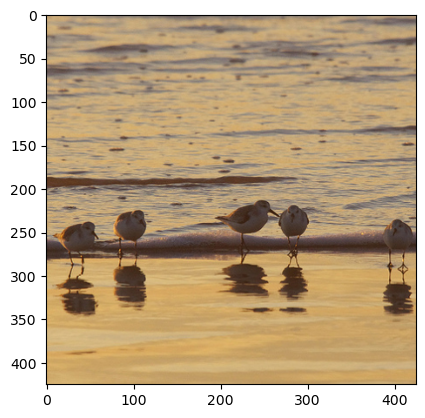

In [7]:
plt.imshow(Y["image_data"]["test"][18,:,:,:])

In [115]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

model = 'resnet18'
weights='first'
batch_size = 1000

if weights == "first":
    weight_enum = torch.hub.load("pytorch/vision", "get_model_weights", name=model)
    weights_avail = [weight for weight in weight_enum]
    testmodel = torch.hub.load('pytorch/vision', model, weights=weights_avail[0])

elif weights == "last":
    weight_enum = torch.hub.load("pytorch/vision", "get_model_weights", name=model)
    weights_avail = [weight for weight in weight_enum]
    testmodel = torch.hub.load('pytorch/vision', model, weights=weights_avail[-1])
    
elif weights == "default":
    testmodel = torch.hub.load('pytorch/vision', model, pretrained=True)

elif weights == "random":
    testmodel = torch.hub.load('pytorch/vision', model, pretrained=False)



image_data = test_image_data

n = len(image_data)

for i in range(0, n, batch_size):
    # Convert each numpy image to a PIL image and apply preprocessing.
    batch_imgs = image_data[i:i+batch_size]
    batch_tensors = torch.stack([preprocess(Image.fromarray(img)) for img in batch_imgs]).to(device)
    with torch.no_grad():
        output = torch.nn.functional.softmax(testmodel(batch_tensors), dim=1)
        # out = testmodel(batch_tensors)

Using cache found in /Users/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/Users/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cpu for inference


Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_main


In [116]:
results = utils.pick_n_best(predictions=output, n=3)

sample 0: [('plate', '34.0%'), ('hot pot, hotpot', '23.6%'), ('Crock Pot', '8.4%')]
sample 1: [('cup', '22.2%'), ('soup bowl', '16.2%'), ('candle, taper, wax light', '10.4%')]
sample 2: [('volleyball', '77.4%'), ('rugby ball', '5.5%'), ('croquet ball', '4.2%')]
sample 3: [('tabby, tabby cat', '40.1%'), ('tiger cat', '14.7%'), ('Egyptian cat', '6.5%')]
sample 4: [('speedboat', '28.0%'), ('killer whale, killer, orca, grampus, sea wolf, Orcinus orca', '16.3%'), ('paddle, boat paddle', '12.2%')]
sample 5: [('shopping cart', '17.7%'), ('jinrikisha, ricksha, rickshaw', '16.2%'), ('tricycle, trike, velocipede', '6.9%')]
sample 6: [('electric locomotive', '60.4%'), ('passenger car, coach, carriage', '14.3%'), ('streetcar, tram, tramcar, trolley, trolley car', '4.6%')]
sample 7: [('monitor', '12.4%'), ('desk', '9.0%'), ('desktop computer', '8.3%')]
sample 8: [('bassinet', '24.9%'), ('cradle', '9.6%'), ('toilet seat', '6.8%')]
sample 9: [('suit, suit of clothes', '44.4%'), ('Windsor tie', '17.3%

In [13]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [14]:
model_names = [x for x in avail_models if not (x.startswith('regnet') or x.startswith('wide') or x.startswith('squeeze') )]
model_names = model_names[0:-4]

In [17]:
# Extract representations resulting from probe inputs image_data

import extract_internal_reps

# data_dir = '../DeepNSD/neural_data/natural_scenes_demo/stimulus_set_700'
save_dir = os.getcwd()

# internal_reps = []
# model_2nds = []
repDict = {}

for model in model_names:  #avail_models:
    repDict.clear()
    x1, model_2nd = extract_internal_reps.extract_rep_nsd(model, test_image_data, weights="first")
    repDict[model] = [x1,model_2nd]
    # model_2nds.append(model_2nd)
    # internal_reps.append(x1)
    with open(save_dir + '/reps/' + model + '_internal_rep_classifier_COCO_1000_aran_first_weights.pkl', 'wb') as f:
        pickle.dump(repDict, f)
    print(model + " done")

Using cpu for inference


Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_main


alexnet done
Using cpu for inference


Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /Users/sharvey/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:19<00:00, 18.3MB/s] 


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
